In [1]:
import os

from IPython.display import Latex
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import find_peaks, peak_prominences
from scipy.integrate import simpson

# EDA

In [2]:
# assign number per point in the 11x11 grid
names = ['wn'] + [i for i in range(121)]

s1_path = os.path.join('data', 'S1_bkg_mapA_11x11.txt')
s2_path = os.path.join('data', 'S2_bkg_mapA_11x11.txt')

s1 = pd.read_csv(s1_path, delim_whitespace=True, names=names)
s2 = pd.read_csv(s2_path, delim_whitespace=True, names=names)

s1.head()

,wn,0,1,2,3,4,5,6,7,8,...,111,112,113,114,115,116,117,118,119,120
0,184.0,11.977942,13.795880,24.564039,6.518834,8.654982,21.038538,12.663731,4.563099,23.769987,...,11.505854,14.530693,10.237762,21.346143,7.906324,21.652784,14.143768,19.417584,91.724807,5.548706
1,185.0,12.903638,13.703474,25.398514,9.550134,11.677319,16.896498,13.116098,5.804119,22.642953,...,10.663801,14.180401,10.864942,19.723728,10.019642,23.616328,17.889618,19.370846,90.870344,5.346441
2,186.0,13.022181,13.521960,25.813691,10.147634,12.410180,15.605156,12.970261,6.023841,22.187466,...,10.294041,14.092665,11.135437,19.089159,10.693783,23.921602,18.683708,19.249165,90.861125,5.227106
3,187.0,12.646595,13.195729,26.938186,10.144902,13.511824,14.764290,12.390567,5.847381,20.855562,...,9.510330,14.195345,11.818230,18.161097,11.284741,23.884462,18.833665,19.254515,91.470588,4.841340
4,188.0,11.086520,12.556653,29.521095,8.553948,15.083337,15.352425,10.862662,4.688388,17.690963,...,7.914280,14.660162,13.337211,16.760005,11.415963,22.920739,17.164942,19.549975,93.453007,3.878598


In [3]:
# computation of spectra intensities
s1_intensities = simpson(s1[[i for i in range(121)]].values.T, s1.wn)
s2_intensities = simpson(s2[[i for i in range(121)]].values.T, s2.wn)

# normalization of spectra
s1[[i for i in range(121)]] = s1[[i for i in range(121)]].div(s1_intensities, axis=1)
s2[[i for i in range(121)]] = s2[[i for i in range(121)]].div(s2_intensities, axis=1)

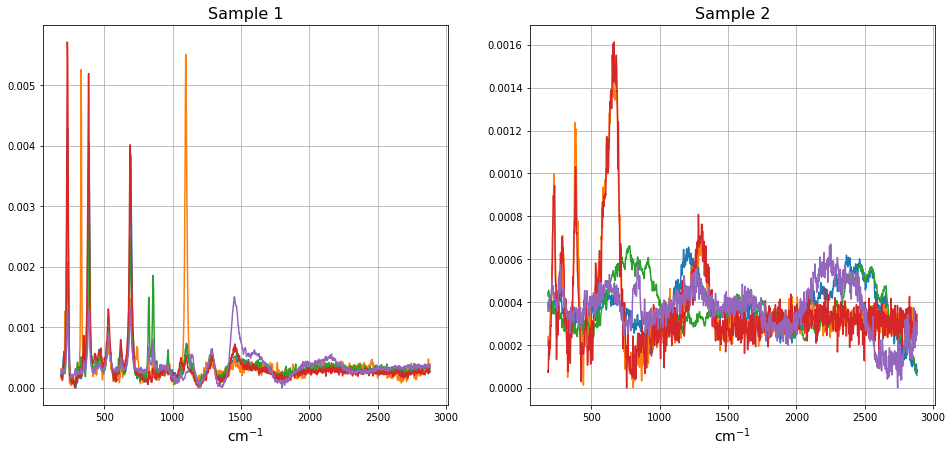

In [4]:
random_sites = np.random.choice(121, replace=False, size=5)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

for site in random_sites:
    ax1.plot(s1.wn, s1[site])
ax1.set_title('Sample 1', fontsize=16)
ax1.set_xlabel('cm$^{-1}$', fontsize=14)
ax1.grid()

for site in random_sites:
    ax2.plot(s1.wn, s2[site])
ax2.set_title('Sample 2', fontsize=16)
ax2.set_xlabel('cm$^{-1}$', fontsize=14)
ax2.grid()

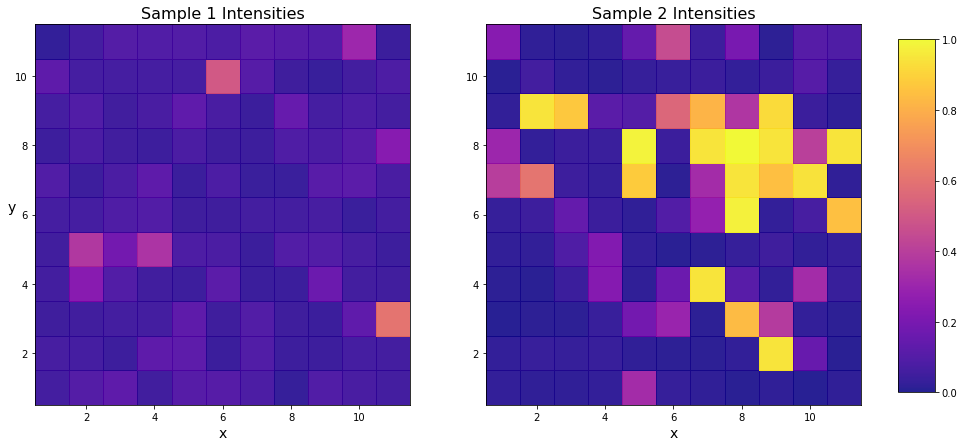

In [5]:
x, y = np.meshgrid(np.arange(1, 12), np.arange(1, 12))

# maximum intensity between the two samples
max_intensity = max(max(s1_intensities), max(s2_intensities))

# plot of intensities per site on a scale between 0 to 1
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 7))

s1_intensity_grid = s1_intensities.reshape(11, 11) / max_intensity
c = ax1.pcolormesh(x, y, s1_intensity_grid, vmin=0, vmax=1,
                   cmap='plasma', alpha=0.9, edgecolors='face')

ax1.set_xlabel('x', fontsize=14)
ax1.set_ylabel('y', fontsize=14, rotation='horizontal')
ax1.set_title('Sample 1 Intensities', fontsize=16)

s2_intensity_grid = s2_intensities.reshape(11, 11) / max_intensity
c = ax2.pcolormesh(x, y, s2_intensity_grid, vmin=0, vmax=1,
                   cmap='plasma', alpha=0.9, edgecolors='face')

ax2.set_xlabel('x', fontsize=14)
ax2.set_title('Sample 2 Intensities', fontsize=16)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.15, 0.03, 0.7])
fig.colorbar(c, cax=cbar_ax)

plt.show()

# Peak detection

## scipy.signal.find_peaks

    Find peaks inside a signal based on peak properties.

    This function takes a 1-D array and finds all local maxima by simple comparison of neighboring values. Optionally, a subset of these peaks can be selected by specifying conditions for a peak’s properties.

The peak properties chosen here are the prominence and the width. 

*The prominence of a peak may be defined as the least drop in height necessary in order to get from the summit to any higher terrain.* [Wikipedia](https://en.wikipedia.org/wiki/Topographic_prominence)

The particular values chosen for the prominence and width are based on inspection of the results of the scipy function on the reference spectra, and are respectively 0.005 and 10. 

In [6]:
# compute position of peaks, number of peaks per site and prominence per peak
s1_peaks, s1_n_peaks, s1_prominences = [], [], []
for i in range(121):
    indexes, properties = find_peaks(s1[i].values, prominence=0.0005, width=10)
    s1_peaks.append(indexes)
    s1_n_peaks.append(indexes.shape[0])
    s1_prominences.append(properties['prominences'])

s1_n_peaks = np.array(s1_n_peaks)
# "weighted" sum of peaks with prominences as weights
s1_w_peaks = np.array([sum(prominces_per_sites) for prominces_per_sites in s1_prominences])

In [7]:
# compute number of peaks per site and prominence per peak
s2_peaks, s2_n_peaks, s2_prominences = [], [], []
for i in range(121):
    indexes, properties = find_peaks(s2[i].values, prominence=0.0005, width=10)
    s2_peaks.append(indexes)
    s2_n_peaks.append(indexes.shape[0])
    s2_prominences.append(properties['prominences'])

s2_n_peaks = np.array(s2_n_peaks)
# "weighted" sum of peaks with prominences as weights
s2_w_peaks = np.array([sum(prominces_per_sites) for prominces_per_sites in s2_prominences])

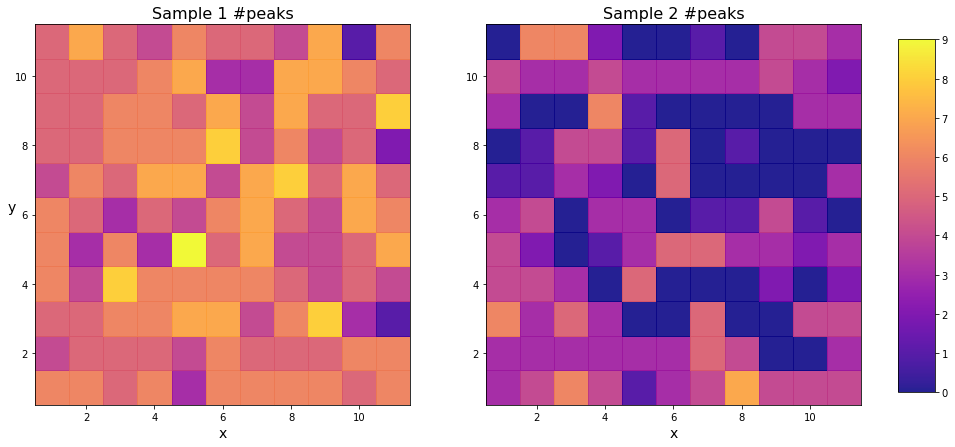

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 7))

max_n_peaks = max(max(s1_n_peaks), max(s2_n_peaks))
c = ax1.pcolormesh(x, y, s1_n_peaks.reshape((11, 11)), vmin=0, vmax=max_n_peaks, 
                   cmap='plasma', alpha=0.9, edgecolors='face')

ax1.set_xlabel('x', fontsize=14)
ax1.set_ylabel('y', fontsize=14, rotation='horizontal')
ax1.set_title('Sample 1 #peaks', fontsize=16)

c = ax2.pcolormesh(x, y, s2_n_peaks.reshape((11, 11)), vmin=0, vmax=max_n_peaks, 
                   cmap='plasma', alpha=0.9, edgecolors='face')

ax2.set_xlabel('x', fontsize=14)
ax2.set_title('Sample 2 #peaks', fontsize=16)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.15, 0.03, 0.7])
fig.colorbar(c, cax=cbar_ax)

plt.show()

The number of peaks and their prominence can be considered as a signal of much information there is in the
spectrum. The weighted sum of the peaks per site with prominence as weights is reported in the following graphs, giving a measure of the amount of clear information in a spectrum.

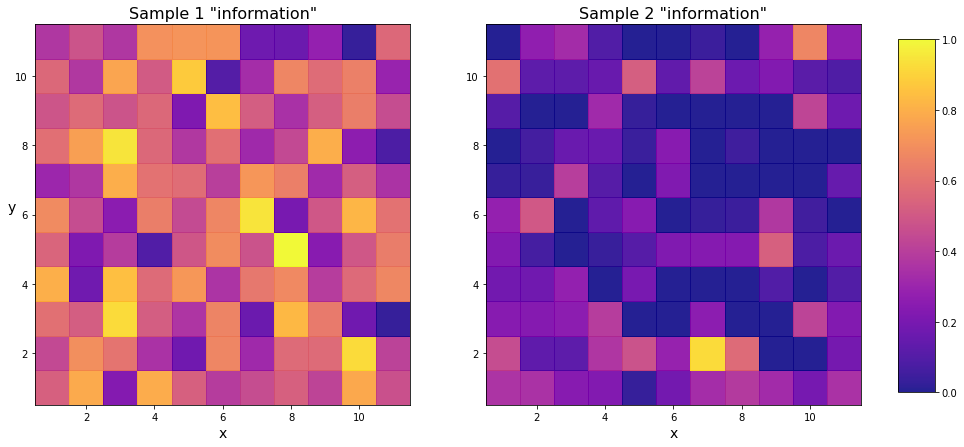

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 7))

max_prominence = max(max(s1_w_peaks), max(s2_w_peaks))
c = ax1.pcolormesh(x, y, s1_w_peaks.reshape((11, 11)) / max_prominence, 
                   vmin=0, vmax=1, cmap='plasma', alpha=0.9, edgecolors='face')

ax1.set_xlabel('x', fontsize=14)
ax1.set_ylabel('y', fontsize=14, rotation='horizontal')
ax1.set_title('Sample 1 "information"', fontsize=16)

c = ax2.pcolormesh(x, y, s2_w_peaks.reshape((11, 11)) / max_prominence, 
                   vmin=0, vmax=1, cmap='plasma', alpha=0.9, edgecolors='face')

ax2.set_xlabel('x', fontsize=14)
ax2.set_title('Sample 2 "information"', fontsize=16)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.15, 0.03, 0.7])
fig.colorbar(c, cax=cbar_ax)

plt.show()

This "*information measure*" can also be used to determine the range of the spectrum of most interest. By
summing the number of peaks over the spectrum position, weighted with their relative prominence, the following
cumulative distribution function is obtained.

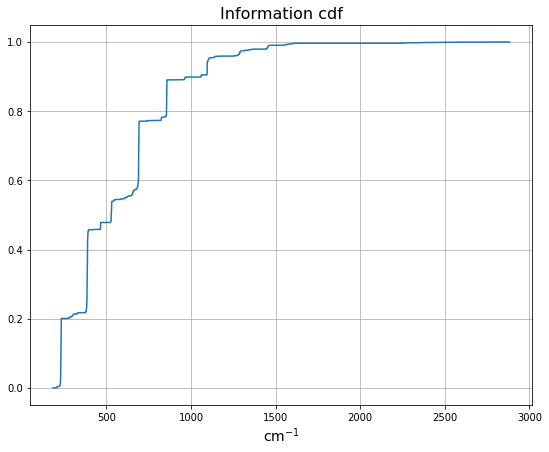

In [10]:
cdf = np.zeros(len(s1.wn))
for ind, prom in zip(s1_peaks, s1_prominences):
    cdf[ind] += prom
    
for ind, prom in zip(s2_peaks, s2_prominences):
    cdf[ind] += prom
    
cdf = np.cumsum(cdf) / np.sum(cdf)

plt.figure(figsize=(9, 7))
plt.plot(s1.wn, cdf)
plt.title('Information cdf', fontsize=16)
plt.xlabel('cm$^{-1}$', fontsize=14)

plt.grid()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

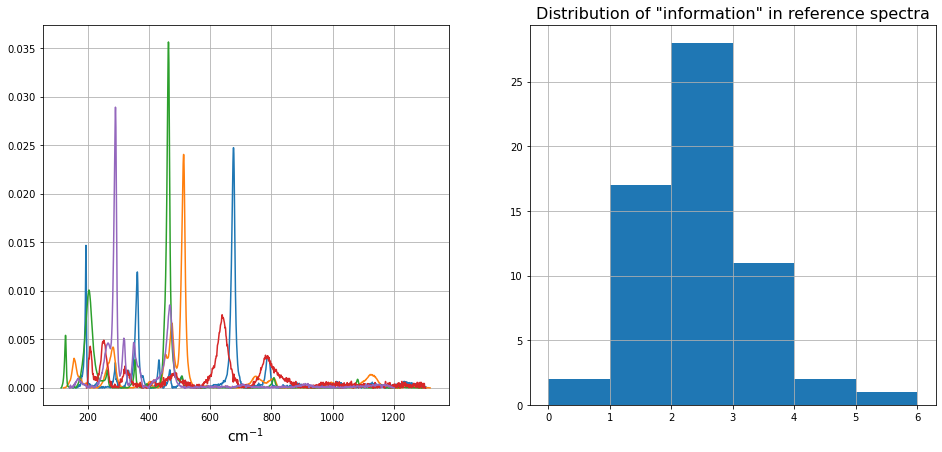

In [11]:
reference_path = os.path.join('data', 'Database Raman')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

n_labels = len(os.listdir(reference_path)) - 2
random_ref = np.random.choice(n_labels, replace=False, size=5)

reference_prominences = []
for i, filename in enumerate(os.listdir(reference_path)):
    # avoid non spectra files
    if sum(s.isupper() for s in filename) < 2:
        filename = os.path.join(reference_path, filename)
        
        # compute normalization of spectrum
        norm = simpson(np.loadtxt(filename)[1:-1, 1], np.loadtxt(filename)[1:-1, 0])
        
        if i in random_ref:
            ax1.plot(np.loadtxt(filename)[1:-1, 0], np.loadtxt(filename)[1:-1, 1] / norm)
            
        peaks = find_peaks(np.loadtxt(filename)[1:-1, 1] / norm, prominence=0.0005, width=10)
        reference_prominences.append(np.sum(peaks[1]['prominences']))

reference_prominences = np.array(reference_prominences) / max_prominence

display(Latex(f'$\overline{{\mu}} = {np.mean(reference_prominences):.2f}$'))
display(Latex(f'$\overline{{\sigma}} = {np.std(reference_prominences):.2f}$'))

ax1.grid()
ax1.set_xlabel('cm$^{-1}$', fontsize=14)
ax2.set_title('Reference spectra examples')

ax2.hist(reference_prominences, bins=np.arange(7))
ax2.set_title('Distribution of "information" in reference spectra', fontsize=16)
ax2.set_xticks(np.arange(7))
ax2.grid()

As can be seen by inspection and by the distribuiton of "information" (normalized to the maximum value in the 
2 samples) of the reference spectra, the samples' data are much more noisy.

# Classifier

The classifier is a function that takes as input a spectrum or an array of spectra and return a dictionary with percentages of the materials in the spectrum.

A linear combination of the reference spectra is found using the function [nnls](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.nnls.html#scipy.optimize.nnls) from scipy.
Before using the least square method the reference spectra are interpolated with a cubic spline on the overlapping domain of the reference spectra and the target one.



In [12]:
from classifier import classify_sample

s1_results, s1_labels = classify_sample(s1_path)
s2_results, s2_labels = classify_sample(s2_path)

A coefficients is considered to be meaningfull only if its contribution to the reconstruction is bigger
than 20 %. This number is arbitrary, it is a very conservative threshold but it was choosen by inspection 
of the results on the two samples. As a consequence not every spectrum in the samples is classifiable.

In [13]:
s1_success = np.unique(np.where(np.array(s1_results) != -1)[0]).shape[0] / 121
s2_success = np.unique(np.where(np.array(s2_results) != -1)[0]).shape[0] / 121

print('Classification success:')
print(f'- Sample 1 {s1_success*100:.2f}%')
print(f'- Sample 2 {s2_success*100:.2f}%')

Classification success:
- Sample 1 79.34%
- Sample 2 22.31%


The second sample "performance" of the classifier is much worse, but that's due to the much worse data. Sample
2, as said before, contains much less *information* and much more noise than sample 1.

[ 2  1  1  1  2  1  1  1  1  1  2  1  1  1  1  1  1  1  1  1  1 61  1  1
  1  1  1 61 61  1  1  1 61  1 61  1  1  1 61  1  1  1  2  1 61 61  1 61
 61  1  1  1 61  1  2  1  1  1  1  1  2  1 61  1  1  2  1 61  1  1  1  1
  1  1 61  1  1  1  1  1  2 61  1 61  1  1  1 61  1  1  1  1 61  1  1  1
  1  2 61  1  1  1  1  1 61  1  1  1  1  1  1 61  1  1  1  1 61 61 61 61
  1  2  1  1 61 61 61 61 61 61 61 61  1 61 61 61  1 61  2  2 61 61 61 61
 61 61  1 61 61 61 61 61  2 61 61 61  1 61 61 61 61 61 61 61 61 61 61 61
 61 61 61 61 61  2 61 61  2  1 61 61  1 61 61  2  1 61 61 61 61  1 61 61
 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61  1 61 61 61
 61 61  1  1  1 61 61 61  1 61  1 61 61 61 61 61  1  1 61 61 61 61 61 61
  2  1]


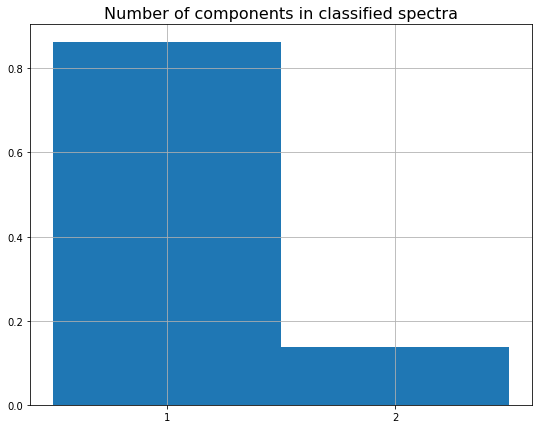

In [18]:
results = np.concatenate((np.array(s1_results), np.array(s2_results)), axis=0)

# count number of components per site
n_coeff = np.count_nonzero(results, axis=1)
n_coeff = n_coeff[n_coeff < 61]

plt.figure(figsize=(9, 7))
plt.hist(n_coeff, bins=np.arange(1, 4), align='left', density=True)

plt.title("Number of components in classified spectra", fontsize=16)
plt.xticks([1, 2])
plt.grid()

# Clustering

Now, using the results of the classifier, the clustering become almost trivial, since most of spectra are
classified as composed of just one of the reference spectra.

/tmp/ipykernel_7469/1261513820.py:13: ConvergenceWarning: Number of distinct clusters (13) found smaller than n_clusters (14). Possibly due to duplicate points in X.
  kmeans.fit(s2_results)
/tmp/ipykernel_7469/1261513820.py:13: ConvergenceWarning: Number of distinct clusters (13) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  kmeans.fit(s2_results)
/tmp/ipykernel_7469/1261513820.py:13: ConvergenceWarning: Number of distinct clusters (12) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  kmeans.fit(s2_results)
/tmp/ipykernel_7469/1261513820.py:13: ConvergenceWarning: Number of distinct clusters (12) found smaller than n_clusters (17). Possibly due to duplicate points in X.
  kmeans.fit(s2_results)
/tmp/ipykernel_7469/1261513820.py:13: ConvergenceWarning: Number of distinct clusters (12) found smaller than n_clusters (18). Possibly due to duplicate points in X.
  kmeans.fit(s2_results)
/tmp/ipykernel_7469/1261513820.py:8: Converge

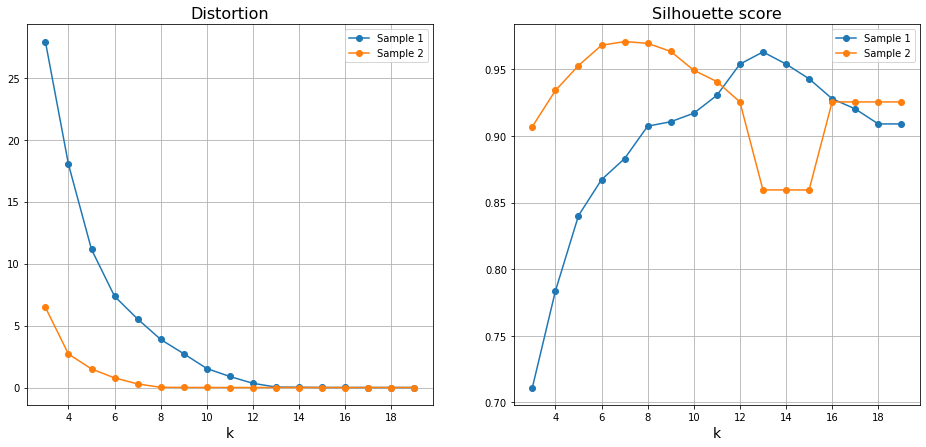

In [15]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

s1_inertia, s1_silhouette = [], []
s2_inertia, s2_silhouette = [], []
for k in range(3, 20):
    kmeans = KMeans(k)
    kmeans.fit(s1_results)
    s1_inertia.append(kmeans.inertia_)
    s1_silhouette.append(silhouette_score(s1_results, kmeans.labels_))
    
    kmeans = KMeans(k)
    kmeans.fit(s2_results)
    s2_inertia.append(kmeans.inertia_)
    s2_silhouette.append(silhouette_score(s2_results, kmeans.labels_))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

ax1.plot(np.arange(3, 20), s1_inertia, label='Sample 1', marker='o')
ax1.plot(np.arange(3, 20), s2_inertia, label='Sample 2', marker='o')
ax1.set_title('Distortion', fontsize=16)
ax1.set_xlabel('k', fontsize=14)
ax1.legend()
ax1.grid()

ax2.plot(np.arange(3, 20), s1_silhouette, label='Sample 1', marker='o')
ax2.plot(np.arange(3, 20), s2_silhouette, label='Sample 2', marker='o')
ax2.set_title('Silhouette score', fontsize=16)
ax2.set_xlabel('k', fontsize=14)
ax2.legend()
ax2.grid()

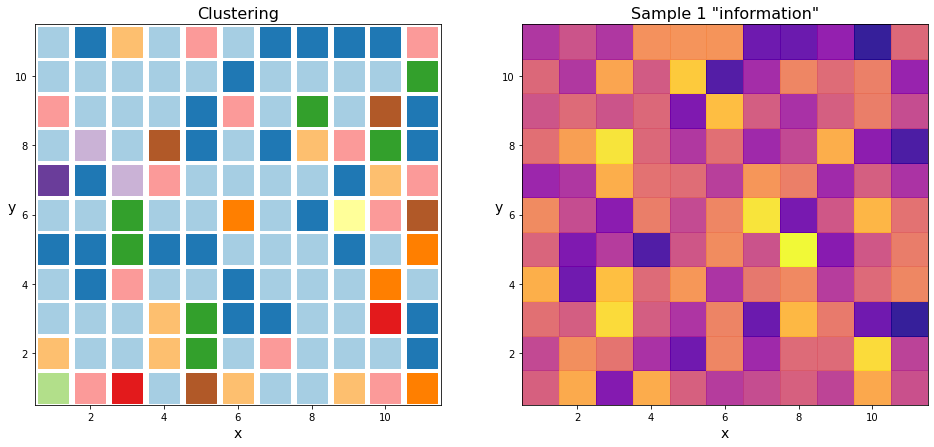

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

labels = KMeans(n_clusters=13).fit_predict(s1_results)

ax1.scatter(x, y, c=labels, s=900, marker='s', cmap='Paired')
ax1.set_xlabel('x', fontsize=14)
ax1.set_ylabel('y', fontsize=14, rotation='horizontal')
ax1.set_title('Clustering', fontsize=16)

c = ax2.pcolormesh(x, y, s1_w_peaks.reshape((11, 11)) / max_prominence, 
                   vmin=0, vmax=1, cmap='plasma', alpha=0.9, edgecolors='face')

ax2.set_xlabel('x', fontsize=14)
ax2.set_ylabel('y', fontsize=14, rotation='horizontal')
ax2.set_title('Sample 1 "information"', fontsize=16)

plt.show()

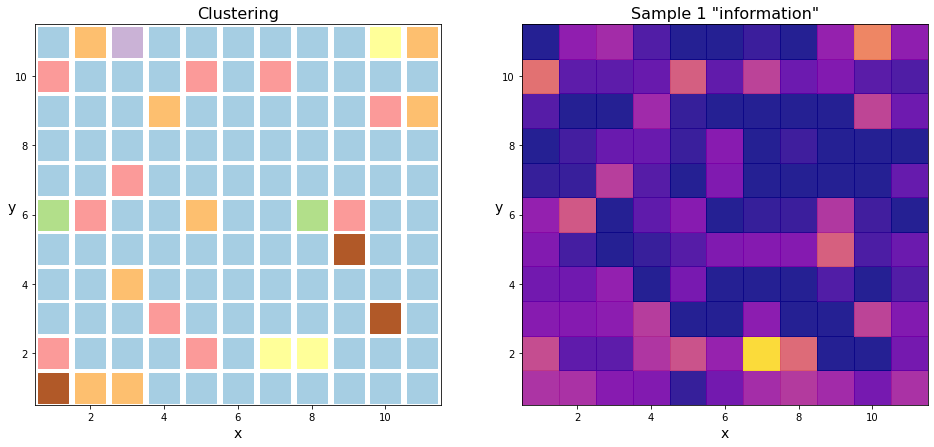

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

labels = KMeans(n_clusters=7).fit_predict(s2_results)

ax1.scatter(x, y, c=labels, s=900, marker='s', cmap='Paired')
ax1.set_xlabel('x', fontsize=14)
ax1.set_ylabel('y', fontsize=14, rotation='horizontal')
ax1.set_title('Clustering', fontsize=16)

c = ax2.pcolormesh(x, y, s2_w_peaks.reshape((11, 11)) / max_prominence, 
                   vmin=0, vmax=1, cmap='plasma', alpha=0.9, edgecolors='face')

ax2.set_xlabel('x', fontsize=14)
ax2.set_ylabel('y', fontsize=14, rotation='horizontal')
ax2.set_title('Sample 1 "information"', fontsize=16)

plt.show()